# Simple Moving Average Cross Over Strategy on Minute Bar Data

# Import

In [1]:
import talib
from jupyterbacktest import *

# Parameter

In [2]:
STOCK = 'SPY'
FAST_MA_RANGE = (10, 50, 200, )
SLOW_MA_RANGE = (100, 500, 2000,)
CONSEC_RANGE = (5, 15, )
RBFQ_RANGE = (5, 15, 60)
START_DATE = '2020-10-01'

# Strategy

In [3]:
def MA_Strategy(stock, fast=50, slow=200, consec=5, rbfq=5):
    class Strg(Strategy):
        _name = f'macross({fast},{slow})_consec({consec})_rbfq({rbfq})'
        def step(self, i, today, broker):
            if i==0:
                self._signal = 0
                broker.trade_stock_target_weight(stock, 0.5)
            elif i%rbfq==0:
                ohlcv = self.market.get_stock_ohlcv_window_at(stock, today, slow+20)
                mafast = talib.MA(ohlcv.close, fast).dropna() 
                maslow = talib.MA(ohlcv.close, slow).dropna()
                madiff = mafast - maslow
                above, below = madiff > 0, madiff < 0
                if above[-consec:].all():                    
                    if self._signal == 0:
                        # up trend, full position
                        broker.trade_stock_target_weight(stock, +1.0)
                        self._signal = 1
                elif below[-consec:].all():
                    if self._signal == 1:
                        # down trend, empty position
                        broker.close_all_stocks()
                        self._signal = 0
    return Strg

In [4]:
bt0 = Backtest([
    long(f'{STOCK} 1.0'),
],[
    *(MA_Strategy(STOCK, fast=f, slow=s, consec=c, rbfq=r)
      for f in FAST_MA_RANGE
      for s in SLOW_MA_RANGE
      for c in CONSEC_RANGE
      for r in RBFQ_RANGE
      if f<s)
],
    barsize='5min',
    window=2500,
    start=START_DATE
)

Altogether will run 49 strategies


In [5]:
bt0.run(parallel=True)

[2020-11-21, 20:42:49] Total 49 backtests started	(2020-10-01 - 2020-11-19)


2020-11-21 20:42:50,703	INFO services.py:1090 -- View the Ray dashboard at http://127.0.0.1:8265


(pid=15596) 	[2020-11-21, 20:43:03] RUNNING	| #1 : macross(10,100)_consec(5)_rbfq(5)
(pid=17704) 	[2020-11-21, 20:43:03] RUNNING	| #0 : P('SPY +1.0', rbfq=10)
(pid=17460) 	[2020-11-21, 20:43:03] RUNNING	| #2 : macross(10,100)_consec(5)_rbfq(15)
(pid=17704) 	[2020-11-21, 20:43:05] RUNNING	| #3 : macross(10,100)_consec(5)_rbfq(60)
(pid=17460) 	[2020-11-21, 20:43:06] RUNNING	| #4 : macross(10,100)_consec(15)_rbfq(5)
(pid=17704) 	[2020-11-21, 20:43:06] RUNNING	| #5 : macross(10,100)_consec(15)_rbfq(15)
(pid=15596) 	[2020-11-21, 20:43:08] RUNNING	| #6 : macross(10,100)_consec(15)_rbfq(60)
(pid=17704) 	[2020-11-21, 20:43:08] RUNNING	| #7 : macross(10,500)_consec(5)_rbfq(5)
(pid=15596) 	[2020-11-21, 20:43:10] RUNNING	| #8 : macross(10,500)_consec(5)_rbfq(15)
(pid=17460) 	[2020-11-21, 20:43:11] RUNNING	| #9 : macross(10,500)_consec(5)_rbfq(60)
(pid=15596) 	[2020-11-21, 20:43:12] RUNNING	| #10: macross(10,500)_consec(15)_rbfq(5)
(pid=17460) 	[2020-11-21, 20:43:12] RUNNING	| #11: macross(10,500)

In [6]:
rslt0 = bt0.result(top=10, by='Sharpe')

In [7]:
rslt0.metrics(formatted=True)

,Return,CAGR,Mu,Std,Sharpe,Calmar,MDD,MDDdur,MDDloc
"P('SPY +1.0', rbfq=10)",+5.3%,+45.9%,+38.3%,22.8%,+1.679,+4.361,-8.8%,2674d,2020-10-12 - 2020-10-30
"macross(50,100)_consec(5)_rbfq(60)",+9.8%,+99.3%,+69.9%,16.5%,+4.229,+27.982,-2.5%,355d,2020-10-16 - 2020-10-20
"macross(200,2000)_consec(5)_rbfq(5)",+7.2%,+66.9%,+51.9%,17.8%,+2.918,+12.299,-4.2%,219d,2020-11-09 - 2020-11-10
"macross(200,2000)_consec(5)_rbfq(15)",+6.8%,+62.0%,+48.9%,17.8%,+2.752,+11.572,-4.2%,219d,2020-11-09 - 2020-11-10
"macross(200,2000)_consec(15)_rbfq(5)",+6.7%,+61.0%,+48.3%,17.8%,+2.717,+11.430,-4.2%,219d,2020-11-09 - 2020-11-10
"macross(10,2000)_consec(5)_rbfq(15)",+6.8%,+62.5%,+49.2%,18.4%,+2.669,+11.656,-4.2%,219d,2020-11-09 - 2020-11-10
"macross(50,2000)_consec(15)_rbfq(15)",+6.5%,+59.0%,+47.0%,17.9%,+2.621,+11.129,-4.2%,219d,2020-11-09 - 2020-11-10
"macross(200,2000)_consec(15)_rbfq(15)",+6.4%,+58.2%,+46.5%,17.8%,+2.614,+11.003,-4.2%,219d,2020-11-09 - 2020-11-10
"macross(10,500)_consec(15)_rbfq(5)",+6.2%,+55.9%,+45.0%,17.2%,+2.613,+9.892,-4.5%,634d,2020-11-09 - 2020-11-12
"macross(50,2000)_consec(15)_rbfq(60)",+6.3%,+56.2%,+45.2%,17.7%,+2.545,+10.697,-4.2%,219d,2020-11-09 - 2020-11-10


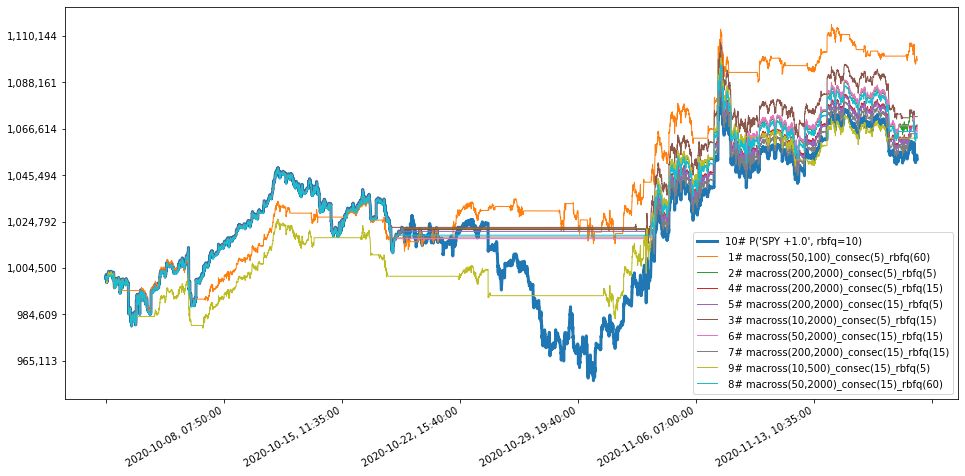

In [8]:
rslt0.plot()

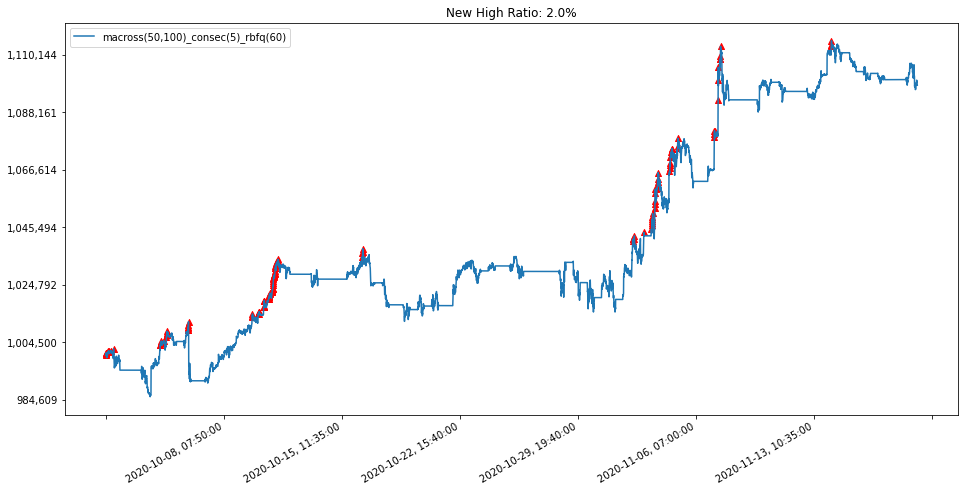

In [9]:
rslt0.plot_new_high(1)